In [1]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import numpy as np

from kalman import *
from computer_vision import *


import tdmclient.notebook
await tdmclient.notebook.start()

# Computer Vision

1


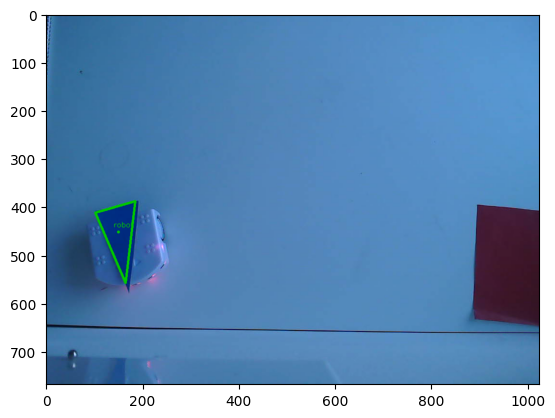

In [2]:
video_capture = cv2.VideoCapture(0,cv2.CAP_DSHOW)
setup_camera(video_capture, -8)
object = 'robot'
video_capture.read(300)
ret, frame = video_capture.read()

centers, contours, img_processed, img_hsv, img_smooth, mask = computer_vision(frame, object, True)
print(len(centers))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

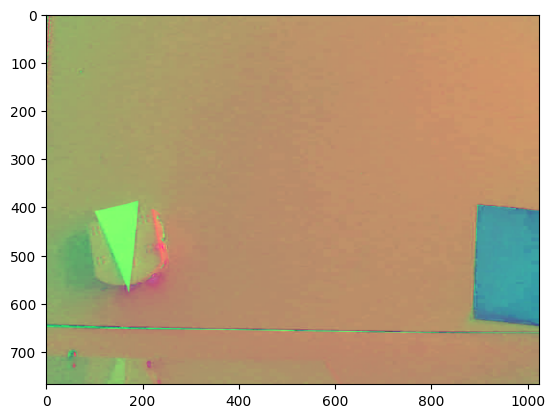

In [3]:
plt.imshow(cv2.cvtColor(img_hsv, cv2.COLOR_BGR2RGB))

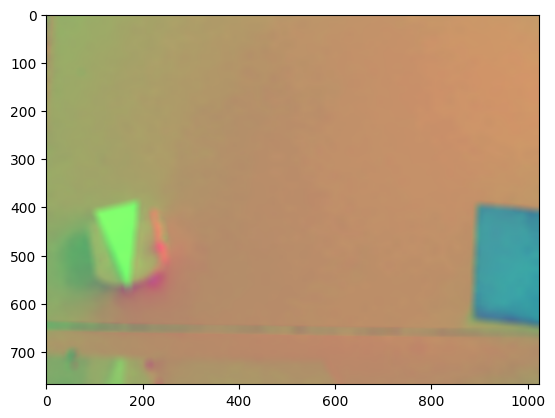

In [4]:
plt.imshow(cv2.cvtColor(img_smooth, cv2.COLOR_BGR2RGB))

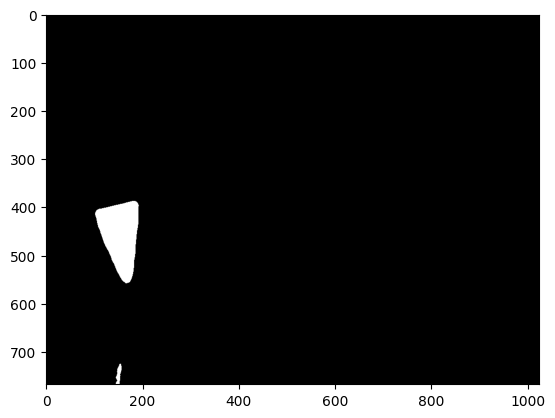

In [5]:
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))

True


True

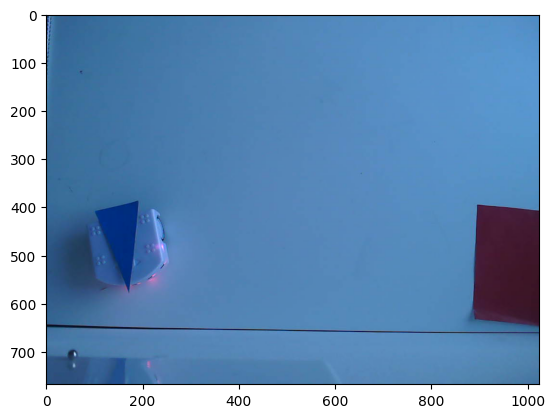

In [6]:
# save all images
cv2.imwrite('images/frame.png', frame)
cv2.imwrite('images/img_processed.png', img_processed)
cv2.imwrite('images/img_hsv.png', img_hsv)
cv2.imwrite('images/img_smooth.png', img_smooth)
cv2.imwrite('images/mask.png', mask)


ret, frame = video_capture.read()
print(ret)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
cv2.imwrite('measurement_frame.jpeg', frame)


# Kalman

In [7]:
MIN_DIST = 30
SPEED_AVG = 250
ROBOT_SPEED_TO_MM = 140/500
ANGLE_TOLERANCE = 0.35
stop = 0

@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500):
    global motor_left_target, motor_right_target
    
    motor_left_target = l_speed
    motor_right_target = r_speed

def get_angle_between(vec1, vec2):
    vec1_unit = vec1 / np.linalg.norm(vec1)
    vec2_unit = vec2 / np.linalg.norm(vec2)

    return np.arccos(np.dot(vec1_unit, vec2_unit))

def distance (x1, y1, x2, y2):
    dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    return dist

def wrap_angle(angle):
    if angle > math.pi:
        angle = angle - 2*math.pi
    elif angle < -math.pi:
        angle = angle + 2*math.pi
    return angle

def controller(angle):
    kp_rot = 40
    kp_lin = 100

    if abs(angle) > ANGLE_TOLERANCE:
        speed_l =  - kp_rot*(angle)
        speed_r =  + kp_rot*(angle)

    else:
        speed_l = SPEED_AVG - kp_lin*(angle)
        speed_r = SPEED_AVG + kp_lin*(angle)
    return int(speed_l), int(speed_r)

def pathing (video_capture, path, x0, y0, theta0):
    cam_hist = []
    kal_hist = []
    pred_hist = []
    theta = 0
    speed_l = speed_r = 0
    goalx = x0 + 600
    goaly = y0 + 150
    theta_measure = 0
    i = 1
    curr_time = 0
    kx = ktheta = ky = angle = 0
    robot_detected = False
    camera_available = False
    dist = distance (goalx, goaly, kx, ky)
    
    # kalman variables 
    P = 1000*np.eye(3)
    x = x_predicted = np.array([[x0],[y0],[theta0]])
    z = np.array([[0],[0],[0]])
    u = np.array([[0],[0]])
    previous_time = 0
    
    previous_time, x, P, x_predicted = kalman_filter(True, x, u, z, P , previous_time)
    while True:       
        #   step 1: get the image, detect the robot, and get the position
        current_time = time.time()
        camera_available, frame = video_capture.read()
        position_measure = []
        if camera_available == True:
            position_measure, position_contour, proccessed_framed, _, _, _ = computer_vision(frame, 'robot', False)
            # cv has detected the robot, we can use the position
            if len(position_measure) == 1:
                robot_detected = True
                position_measure = position_measure[0]

                if position_measure is not None:                    
                    _, theta_measure = get_robot_position(frame, position_measure, position_contour)
                    theta_measure = round(-theta_measure, 4)
                    position_measure = invert_coordinates(position_measure)
                    position_measure = pixel_to_metric(position_measure)
                    [kx, ky, ktheta] = [position_measure[0], position_measure[1], theta_measure]
                    measurement = np.array([kx, ky, ktheta])
                else:
                    robot_detected = False
            else:
            # robot not detected, we use kalman
                robot_detected = False
        
        if camera_available == False or robot_detected == False:
            measurement = np.array([0,0,0])         # CHECK WHY 0,0,0            
        
        z = np.array([[measurement[0]], [measurement[1]], [measurement[2]]])
        previous_time, x, P, x_predicted = kalman_filter(robot_detected, x, u, z, P , previous_time)
        [pred_x, pred_y, pred_theta] = x
        
        
        dist = distance (goalx, goaly, pred_x, pred_y)
        theta = math.atan2((goaly - pred_y), (goalx - pred_x)) #change angle according to kalman
    

        if (dist < MIN_DIST):
            motors(stop, stop)
            break
        else :
            angle =  wrap_angle((theta - pred_theta) % (2*np.pi))
            speed_l, speed_r = controller(angle)
            
   
        u = np.array([[speed_l],[speed_r]]) * ROBOT_SPEED_TO_MM
        motors(speed_l, speed_r)

        cam_hist.append([kx, ky, ktheta])
        kal_hist.append([pred_x, pred_y, pred_theta])
        end_time = time.time()
        
        print(robot_detected, dist, pred_x, pred_y, pred_theta)
    motors(stop, stop)
    
    return cam_hist, kal_hist, pred_hist

In [8]:
cv_successful, obst, robot, goal, frame = cv_start(video_capture, show_image= True, exposure=-7)
start = np.array([robot[0], robot[1]])
start = invert_coordinates(start)
start = pixel_to_metric(start)
start_time = time.time()
cam, kal, pred = pathing(video_capture, None, start[0], start[1], 0)
end_time = time.time()
print("finished")
motors(stop, stop)

True [655.13190457] [119.69634096] [107.82746221] [-0.73233975]
True [657.44231065] [91.58090754] [178.97055286] [-0.98847746]
True [647.76319928] [96.14194894] [198.48027254] [-1.11882434]
True [640.81024081] [101.28284578] [206.29348351] [-1.20135627]
True [636.09149736] [105.55508133] [208.6332341] [-1.24607551]
True [632.94434626] [108.14607516] [211.22223518] [-1.26777582]
True [630.74165738] [110.28498958] [211.74855741] [-1.26593011]
True [628.98720982] [112.02474396] [212.02436712] [-1.25401295]
True [627.70517327] [113.40510871] [211.79398671] [-1.22949919]
True [626.7344903] [114.201746] [212.60432473] [-1.19667475]
True [625.79842828] [115.33281603] [211.94871953] [-1.1599373]
True [625.07474544] [116.08106827] [211.94212497] [-1.11400688]
True [624.43241024] [116.7536774] [211.90313927] [-1.06685323]
True [623.7131066] [117.66285993] [211.24806107] [-1.01246851]
True [623.38349992] [117.93234591] [211.52493089] [-0.95481917]
True [622.96786421] [118.31601361] [211.70242473]

In [9]:
motors(0,0)
cam_copy = np.array(cam)
kal_copy = np.array(kal)
obst_copy  = np.array(obst)

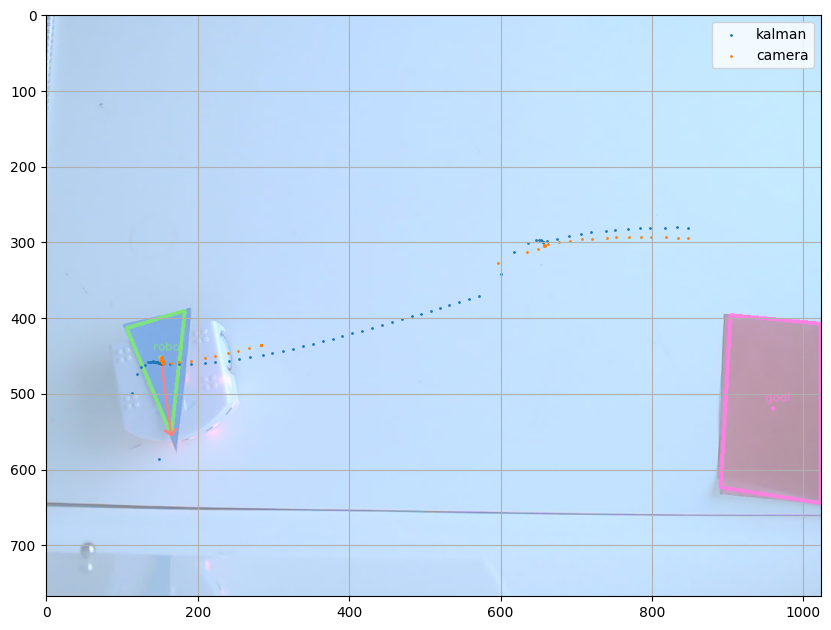

In [10]:
#plot 
pixel_cam = np.zeros(np.shape(cam_copy))
pixel_kal = np.zeros(np.shape(kal_copy))
fig, ax = plt.subplots(figsize=(10,10))
# transform to pixel
for i in range(len(cam)):
    pixel_cam[i] = metric_to_pixel(cam_copy[i])
    pixel_kal[i] = metric_to_pixel(kal_copy[i])


ax.scatter(pixel_kal[:,0], -pixel_kal[:,1] + CAMERA_HEIGHT, label='kalman', s=1)
ax.scatter(pixel_cam[:,0], -pixel_cam[:,1]+ CAMERA_HEIGHT,label='camera', s = 1)

ax.legend()
ax.grid()

ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), origin='upper', alpha=0.5)
fig.savefig('images/kalman.png')


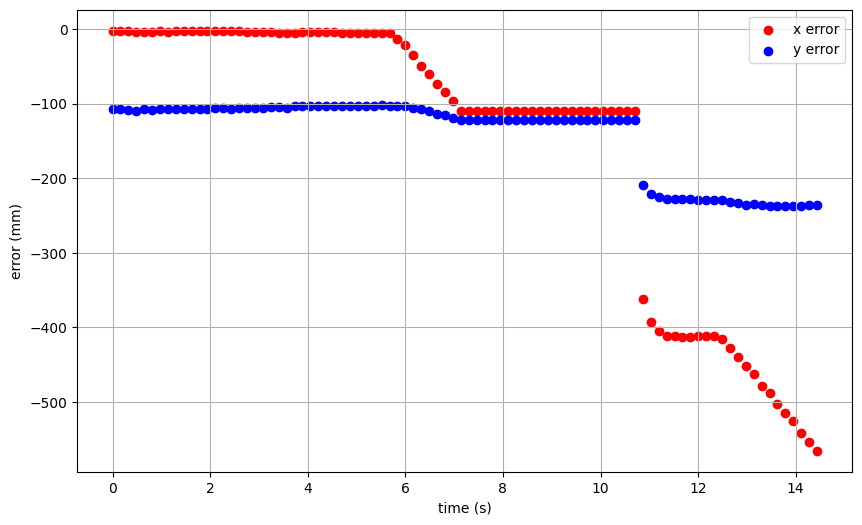

In [11]:
# plot x error, y error, theta error as a function of time
fig, ax = plt.subplots(figsize=(10,6))
time_val = np.linspace(0, (end_time - start_time), len(pixel_kal))

# x error
ax.scatter(time_val, kal_copy[:,0][0] - cam_copy[:,0], label='x error', color='red')
# y error
ax.scatter(time_val, kal_copy[:,1][0] - cam_copy[:,1], label='y error', color='blue')

# axis labels
ax.set_xlabel('time (s)')
ax.set_ylabel('error (mm)')

ax.legend()
ax.grid()
fig.savefig('images/kalman_pos_error.png')


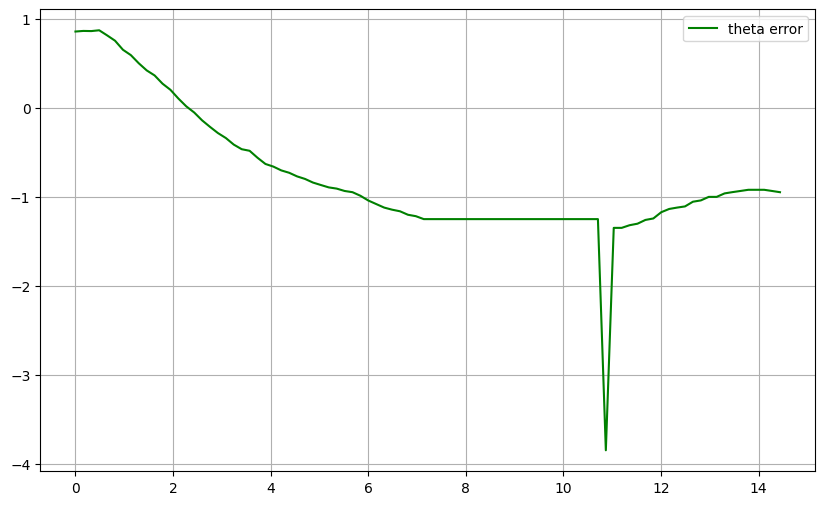

Exception in thread Thread-3:
Traceback (most recent call last):
  File "c:\Users\osour\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "c:\Users\osour\AppData\Local\Programs\Python\Python310\lib\site-packages\tdmclient\tcp.py", line 73, in run
    packet = self.read_packet()
  File "c:\Users\osour\AppData\Local\Programs\Python\Python310\lib\site-packages\tdmclient\tcp.py", line 66, in read_packet
    raise error
  File "c:\Users\osour\AppData\Local\Programs\Python\Python310\lib\site-packages\tdmclient\tcp.py", line 59, in read_packet
    packet_len = self.read_uint32()
  File "c:\Users\osour\AppData\Local\Programs\Python\Python310\lib\site-packages\tdmclient\tcp.py", line 46, in read_uint32
    b = self.io.read(4)
  File "c:\Users\osour\AppData\Local\Programs\Python\Python310\lib\site-packages\tdmclient\tcp.py", line 99, in read
    return self.socket.recv(n)
ConnectionResetError: [WinError 10054] An existing connection w

In [12]:
# theta error
fig1, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(time_val, pixel_kal[:,2][0] - pixel_cam[:,2], label='theta error', color='green')
ax1.legend()
ax1.grid()

fig1.savefig('images/kalman_theta_error.png')

